# Fed Minutes, Text Mining, and Economic Forecasting with ML & Deep NLP

**Teaching goal:** show how economists can start from unstructured central-bank text (FOMC minutes),
turn it into structured numerical data, and then use that data in standard forecasting / classification
tasks, including examples that motivate deep neural networks.

---

## Notebook roadmap

This notebook is organized in **three parts**, each increasing the sophistication of the text method
while keeping the economic questions intuitive:

### Part 1 – Classical NLP + Tiny Neural Net
- **Economic question:** Do the words in FOMC minutes contain information about the future 10-year
  Treasury yield?
- **Data construction:**
  - Scrape FOMC *minutes* from the Federal Reserve website.
  - Pull the 10-year Treasury yield (`DGS10`) from FRED.
  - For each meeting date $t$, construct a **3-week ahead yield change**
    $R_t = y_{t+21\,\text{days}} - y_t$.
- **Models:**
  1. TF–IDF (bag-of-words) + **Ridge regression** (linear model).
  2. TF–IDF + a **small feed-forward neural network (MLP)**.

### Part 2 – Policy Surprise Classification ("Option B")
- **Economic question:** Do FOMC minutes help explain whether a meeting is perceived as
  **hawkish** or **dovish** by markets?
- **Data construction:**
  - Use the 2-year Treasury yield (`DGS2`) as a proxy for expectations of future short rates.
  - For each meeting date, compute the **change in the 2-year yield around the meeting**, and
    label positive moves as *hawkish* and negative moves as *dovish* (above a small threshold).
- **Models:**
  1. TF–IDF + **logistic regression** (linear classifier).
  2. TF–IDF + **MLP classifier** (non-linear neural net).

### Part 3 – Deep Pre-trained Model (FinBERT-FOMC) as Feature Extractor ("Option C")
- **Economic question:** Can we distill FOMC minutes into a **sentiment index** using a deep
  language model, and does that index help explain yield changes?
- **Data construction:**
  - Use **FinBERT-FOMC**, a transformer model fine-tuned on FOMC text.
  - For each minutes document, compute Positive / Negative / Neutral scores and construct a
    scalar sentiment index $s_t = P(\text{Positive}) - P(\text{Negative})$.
- **Model:**
  - Use $s_t$ as an explanatory variable in a simple regression for the 3-week change in the
    10-year yield.

Along the way, we make the econometrics trade-offs explicit:
- Sample size is small (FOMC meets only ~8 times per year), so **we do not expect large $R^2$**.
- The goal is to illustrate the **workflow** and connect it to ideas in the literature,
  not to build a trading strategy.


In [37]:
# If you're running this in a fresh environment (e.g. Google Colab),
# uncomment and run this cell once to install dependencies:
# !pip install requests beautifulsoup4 pandas pandas_datareader scikit-learn lxml matplotlib transformers torch

from typing import List, Dict, Tuple, Any, Optional

import re
import datetime as dt

import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from pandas_datareader import data as pdr

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
)

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 5)
pd.set_option('display.max_colwidth', 120)


---

## Part 1 – FOMC minutes → 10-year yield change (Ridge + tiny neural net)

**Economic motivation:** FOMC minutes summarize the Committee's deliberations and provide guidance
about its view of the economy and policy path. If markets read those minutes and update their
expectations about future short rates, that update should be reflected in longer-term yields.

In practice, many other forces move yields, so we expect **weak predictive power**, but this is a
clean way to show how to connect text to a numerical forecast target.


### 1.1 Scrape FOMC minutes links

We start from the **FOMC calendars** page and collect links to the HTML versions of the minutes.
We restrict ourselves to the modern calendars page, which already provides links to minutes in
HTML form (roughly 2020 onward).

Below we define a small helper function:

- It downloads the calendars page.
- Uses BeautifulSoup to find all `<a>` tags.
- Keeps those whose `href` looks like a minutes HTML file.


In [38]:
CALENDAR_URL: str = 'https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm'

def get_fomc_minutes_urls() -> List[str]:
    """Scrape the FOMC calendar page and return a sorted list of minutes HTML URLs.

    Returns
    -------
    List[str]
        Absolute URLs pointing to FOMC minutes pages (HTML, not PDF).
    """
    resp: requests.Response = requests.get(CALENDAR_URL)
    resp.raise_for_status()
    soup: BeautifulSoup = BeautifulSoup(resp.text, 'lxml')

    urls: set[str] = set()
    for a in soup.find_all('a', href=True):
        href: str = a['href']
        href_lower: str = href.lower()
        # FOMC minutes HTML pages follow this pattern
        if 'fomcminutes' in href_lower and href_lower.endswith('.htm'):
            full_url: str = requests.compat.urljoin(CALENDAR_URL, href)
            urls.add(full_url)

    sorted_urls: List[str] = sorted(urls)
    print(f'Found {len(sorted_urls)} minutes pages.')
    return sorted_urls

minutes_urls: List[str] = get_fomc_minutes_urls()
minutes_urls[:5]

Found 47 minutes pages.


['https://www.federalreserve.gov/monetarypolicy/fomcminutes20200129.htm',
 'https://www.federalreserve.gov/monetarypolicy/fomcminutes20200315.htm',
 'https://www.federalreserve.gov/monetarypolicy/fomcminutes20200429.htm',
 'https://www.federalreserve.gov/monetarypolicy/fomcminutes20200610.htm',
 'https://www.federalreserve.gov/monetarypolicy/fomcminutes20200729.htm']

### 1.2 Parse each minutes page (meeting date + text)

For each minutes page, we want to extract:

- The **meeting date** (as a Python `datetime.date` object).
- The **raw text** of the minutes, which we will later feed into NLP models.

Challenges:
- The meeting date can be written in multiple formats:
  - `April 28–29, 2020`
  - `January 31–February 1, 2023`
  - Or as part of a longer sentence describing a joint meeting.
- Some pages exhibit **mojibake** (e.g. `â\x80\x93` instead of an en dash).

We therefore build a **robust date parser** that handles these cases and always returns the
**last day** of the meeting (since many meetings span two days).


In [39]:
MONTHS: Dict[str, int] = {
    'january': 1, 'february': 2, 'march': 3, 'april': 4,
    'may': 5, 'june': 6, 'july': 7, 'august': 8,
    'september': 9, 'october': 10, 'november': 11, 'december': 12,
}

def parse_meeting_date_str(raw: str) -> dt.date:
    """Parse FOMC meeting date strings into a date, using the *last* day.

    The function is intentionally forgiving and handles patterns such as:

    - "April 28–29, 2020" (real en dash)
    - "April 28â\x80\x9329, 2020" (mojibake en dash)
    - "January 31–February 1, 2023" (cross-month range)
    - "April 30-May 1, 2024" (range with explicit month names)
    - Long sentences like:
      "A joint meeting ... June 15, 2021, ... June 16, 2021, ..."

    Parameters
    ----------
    raw : str
        Raw date string as extracted from the minutes page.

    Returns
    -------
    datetime.date
        Parsed date corresponding to the *last* meeting day.
    """
    s: str = raw.strip()

    # Attempt to fix mojibake like 'April 28â\x80\x9329, 2020' by
    # re-decoding as UTF-8 via latin1 round-trip.
    try:
        s_fixed: str = s.encode('latin1').decode('utf-8')
        s = s_fixed
    except (UnicodeEncodeError, UnicodeDecodeError):
        pass

    # Normalize dashes and whitespace
    s = s.replace('\u2013', '-')  # en dash
    s = s.replace('\u2014', '-')  # em dash
    s = re.sub(r'\s+', ' ', s)

    # PATTERN 1: "Month1 d1-Month2 d2, yyyy" (cross-month range)
    m = re.match(r'([A-Za-z]+)\s+(\d{1,2})\s*-\s*([A-Za-z]+)\s+(\d{1,2}),\s*(\d{4})', s)
    if m:
        month1_name, d1, month2_name, d2, year = m.groups()
        month2: int = MONTHS[month2_name.lower()]
        day2: int = int(d2)
        year_i: int = int(year)
        return dt.date(year_i, month2, day2)

    # PATTERN 2: "Month d1-d2, yyyy" (same-month range)
    m = re.match(r'([A-Za-z]+)\s+(\d{1,2})\s*-\s*(\d{1,2}),\s*(\d{4})', s)
    if m:
        month_name, d1, d2, year = m.groups()
        month: int = MONTHS[month_name.lower()]
        day2 = int(d2)
        year_i = int(year)
        return dt.date(year_i, month, day2)

    # PATTERN 3: one or more "Month d, yyyy" occurrences (possibly in a long sentence).
    # We use the LAST date mentioned.
    matches = re.findall(r'([A-Za-z]+)\s+(\d{1,2}),\s*(\d{4})', s)
    if matches:
        month_name, day, year = matches[-1]
        month = MONTHS[month_name.lower()]
        day_i: int = int(day)
        year_i = int(year)
        return dt.date(year_i, month, day_i)

    # If nothing matched, give up.
    raise ValueError(f'Could not parse meeting date string: {raw!r}')


def parse_minutes_page(url: str) -> Dict[str, Any]:
    """Parse one FOMC minutes HTML page.

    Parameters
    ----------
    url : str
        URL of the minutes HTML page.

    Returns
    -------
    Dict[str, Any]
        Dictionary with keys:
        - 'url': the URL
        - 'meeting_date': `datetime.date` of the meeting (last day)
        - 'meeting_date_str': raw meeting date string from the page
        - 'text': concatenated body text of the minutes
    """
    resp: requests.Response = requests.get(url)
    resp.raise_for_status()
    soup: BeautifulSoup = BeautifulSoup(resp.text, 'lxml')
    full_text: str = soup.get_text('\n')

    # Split into non-empty lines
    lines: List[str] = [ln.strip() for ln in full_text.splitlines() if ln.strip()]

    # Locate the header line
    try:
        idx: int = next(i for i, ln in enumerate(lines)
                       if 'Minutes of the Federal Open Market Committee' in ln)
    except StopIteration:
        raise ValueError('Header line not found in page: ' + url)

    # Meeting date string is the next non-empty line
    meeting_date_str: str = lines[idx + 1]
    meeting_date: dt.date = parse_meeting_date_str(meeting_date_str)

    # Body: from two lines after header until 'Last Update:' (if present)
    start: int = idx + 2
    try:
        end: int = next(i for i, ln in enumerate(lines[start:], start)
                      if ln.startswith('Last Update:'))
    except StopIteration:
        end = len(lines)

    body_lines: List[str] = lines[start:end]
    body_text: str = '\n'.join(body_lines)

    return {
        'url': url,
        'meeting_date': meeting_date,
        'meeting_date_str': meeting_date_str,
        'text': body_text,
    }

# Parse all minutes pages
records: List[Dict[str, Any]] = []
for url in minutes_urls:
    try:
        rec = parse_minutes_page(url)
        records.append(rec)
    except Exception as e:
        print(f'Failed to parse {url}: {e}')

minutes_df: pd.DataFrame = pd.DataFrame(records).sort_values('meeting_date').reset_index(drop=True)
print(f'Parsed {len(minutes_df)} minutes documents.')
minutes_df.head()

Parsed 47 minutes documents.


,url,meeting_date,meeting_date_str,text
0,https://www.federalreserve.gov/monetarypolicy/fomcminutes20200129.htm,2020-01-29,"January 28-29, 2020",A joint meeting of the Federal Open Market Committee and the Board of Governors was held in the offices of the Board...
1,https://www.federalreserve.gov/monetarypolicy/fomcminutes20200315.htm,2020-03-15,"March 15, 2020",A joint meeting of the Federal Open Market Committee and the Board of Governors was held by videoconference on Sunda...
2,https://www.federalreserve.gov/monetarypolicy/fomcminutes20200429.htm,2020-04-29,"April 28â29, 2020",A joint meeting of the Federal Open Market Committee and the Board of Governors was held by conference call on Tuesd...
3,https://www.federalreserve.gov/monetarypolicy/fomcminutes20200610.htm,2020-06-10,"June 9-10, 2020",A joint meeting of the Federal Open Market Committee and the Board of Governors was held by videoconference on Tuesd...
4,https://www.federalreserve.gov/monetarypolicy/fomcminutes20200729.htm,2020-07-29,"July 28-29, 2020",A joint meeting of the Federal Open Market Committee and the Board of Governors was held by videoconference on Tuesd...


### 1.3 Pull 10-year yields and define a 3-week ahead target

We now bring in the **financial data** that we want to forecast.

- We use the daily FRED series `DGS10` (10-year constant maturity Treasury yield).
- For each meeting date $t$, we define the target as the **3-week (21-day) change** in the yield:
  \[
  R_t = y_{t+21\,\text{days}} - y_t.
  \]
- Economically, this is a crude measure of how much the 10-year yield moves over a short
  horizon after the minutes are released.

We do *not* claim this is an optimal or structural definition of a policy shock—it is simply a
transparent, teachable target.


In [40]:
if minutes_df.empty:
    raise RuntimeError('No minutes were parsed; check the scraping steps above.')

min_date: dt.date = minutes_df['meeting_date'].min()
max_date: dt.date = minutes_df['meeting_date'].max()

# Extend the window to cover the forward horizon
HORIZON_DAYS: int = 21
start_date: dt.date = min_date - dt.timedelta(days=7)
end_date: dt.date = max_date + dt.timedelta(days=HORIZON_DAYS + 7)

print('Minutes from', min_date, 'to', max_date)
print('Fetching DGS10 from', start_date, 'to', end_date)

dgs10: pd.DataFrame = pdr.DataReader('DGS10', 'fred', start_date, end_date)
dgs10 = dgs10.rename(columns={'DGS10': 'dgs10'})

# Ensure numeric, then forward-fill gaps (weekends/holidays) and drop leading NaNs
dgs10['dgs10'] = pd.to_numeric(dgs10['dgs10'], errors='coerce')
dgs10 = dgs10.sort_index().ffill().dropna()
dgs10.head()

Minutes from 2020-01-29 to 2025-10-29
Fetching DGS10 from 2020-01-22 to 2025-11-26


,dgs10
DATE,
2020-01-22,1.77
2020-01-23,1.74
2020-01-24,1.70
2020-01-27,1.61
2020-01-28,1.65


In [41]:
def get_yield_on_or_before(date: dt.date) -> float:
    """Return the last available DGS10 yield on or before a given calendar date.

    This approximates the yield that markets observe *by* the meeting date.
    """
    ts: pd.DataFrame = dgs10.loc[:pd.to_datetime(date)]
    if ts.empty:
        return float('nan')
    return float(ts['dgs10'].iloc[-1])


def get_yield_on_or_before_plus_days(date: dt.date, days: int) -> float:
    """Return the last available DGS10 yield on or before (date + days)."""
    target_date: dt.date = date + dt.timedelta(days=days)
    ts: pd.DataFrame = dgs10.loc[:pd.to_datetime(target_date)]
    if ts.empty:
        return float('nan')
    return float(ts['dgs10'].iloc[-1])


minutes_df['yield_t'] = minutes_df['meeting_date'].apply(get_yield_on_or_before)
minutes_df['yield_t_plus'] = minutes_df['meeting_date'].apply(
    lambda d: get_yield_on_or_before_plus_days(d, HORIZON_DAYS)
)
minutes_df['target_return'] = minutes_df['yield_t_plus'] - minutes_df['yield_t']

minutes_df[['meeting_date', 'yield_t', 'yield_t_plus', 'target_return']].tail()

,meeting_date,yield_t,yield_t_plus,target_return
42,2025-05-07,4.26,4.47,0.21
43,2025-06-18,4.38,4.34,-0.04
44,2025-07-30,4.38,4.29,-0.09
45,2025-09-17,4.06,4.13,0.07
46,2025-10-29,4.08,4.13,0.05


### 1.4 Text → TF–IDF features → Ridge regression

Now we connect the **text** of the minutes to the **numerical target** (3-week yield change).

**Step 1 – Text representation (TF–IDF)**
- We use `TfidfVectorizer` to construct a document-term matrix:
  - Unigrams + bigrams (single words and word pairs).
  - Remove very common and very rare terms.
  - Remove English stopwords ("the", "and", ...).
- The result is a high-dimensional, sparse numerical representation of each meeting.

**Step 2 – Regression model (Ridge)**
- We fit a **Ridge regression** model (linear regression with $L^2$ penalty) on these features.
- Economically, we are asking: is there a **linear combination** of words/phrases whose
  variation helps predict yield changes?


We have 47 meetings with a valid target (3-week 10Y change).
Ridge regression:
  Test RMSE        : 0.2667 percentage points
  Baseline RMSE    : 0.2656 (predict train mean)
  Test R^2         : -0.015


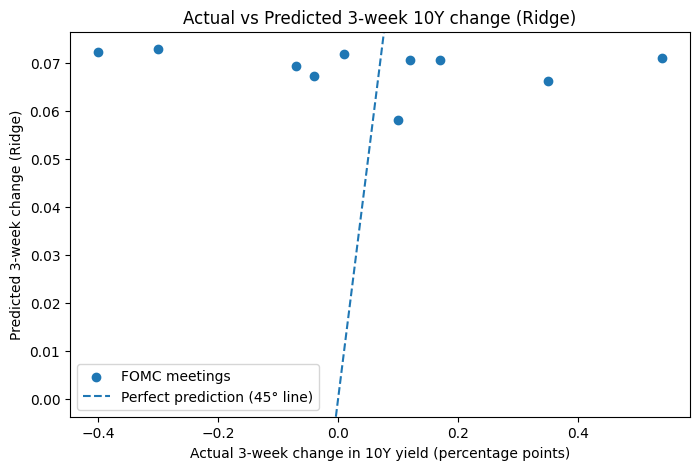

In [42]:
data: pd.DataFrame = minutes_df.dropna(subset=['target_return']).copy()
print(f'We have {len(data)} meetings with a valid target (3-week 10Y change).')

X_text: np.ndarray = data['text'].values
y: np.ndarray = data['target_return'].values

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42
)

tfidf_ridge: Pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 2),
        max_df=0.95,
        min_df=2,
        stop_words='english',
    )),
    ('ridge', Ridge(alpha=10.0)),
])

tfidf_ridge.fit(X_train, y_train)
y_pred_ridge: np.ndarray = tfidf_ridge.predict(X_test)

mse_ridge: float = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge: float = float(np.sqrt(mse_ridge))
r2_ridge: float = float(r2_score(y_test, y_pred_ridge))

# Baseline: always predict the mean of y_train
baseline_pred: float = float(np.mean(y_train))
baseline_rmse: float = float(np.sqrt(mean_squared_error(y_test, np.full_like(y_test, baseline_pred))))

print('Ridge regression:')
print(f'  Test RMSE        : {rmse_ridge:.4f} percentage points')
print(f'  Baseline RMSE    : {baseline_rmse:.4f} (predict train mean)')
print(f'  Test R^2         : {r2_ridge:.3f}')

plt.scatter(y_test, y_pred_ridge, label='FOMC meetings')
plt.axline((0, 0), slope=1, linestyle='--', label='Perfect prediction (45° line)')
plt.xlabel('Actual 3-week change in 10Y yield (percentage points)')
plt.ylabel('Predicted 3-week change (Ridge)')
plt.title('Actual vs Predicted 3-week 10Y change (Ridge)')
plt.legend()
plt.show()

#### How to read the scatter plots

- **Each dot** is one FOMC meeting: its x–coordinate is the **actual** 3‑week change in the 10‑year yield,
  and its y–coordinate is the **predicted** change from the model.
- The **dashed 45° line** is where a point would lie if the model were **exactly right** for that meeting
  (predicted change = actual change).
- The **distance from the dashed line** shows the prediction error for that meeting.
- If dots are tightly clustered around the dashed line, the model is doing well; if they are scattered
  far away, the model has large errors.


**Interpretation of Part 1 results:**

- The **RMSE** tells us the typical absolute prediction error in percentage points. Comparing it to
  the **baseline RMSE** (always predicting the sample mean) shows whether the text model adds any
  predictive power beyond a naive forecast.
- The **$R^2$** indicates the fraction of variance in the 3-week yield change explained by the model.
  With a small sample and a very noisy target, it is common to see $R^2$ close to zero or even
  negative (worse than baseline).
- For teaching, emphasize that the goal here is to understand the *pipeline* rather than to claim
  that minutes alone can forecast yields with high precision.


### 1.5 TF–IDF + tiny neural network (MLPRegressor)

To introduce **neural networks** at a gentle level, we keep the same TF–IDF representation but
replace Ridge regression with a small **multi-layer perceptron (MLP)** regressor.

Key ideas for students:
- An MLP is just a sequence of linear transformations + non-linear activation functions (here ReLU).
- With at least one hidden layer, the model can represent more complex, non-linear relationships
  between text features and the target.
- However, with our **small sample size**, we must be careful not to over-interpret any performance
  gains (and we may even see worse performance due to overfitting).


MLP regression:
  Test RMSE        : 0.2767 percentage points
  Baseline RMSE    : 0.2656 (predict train mean)
  Test R^2         : -0.092


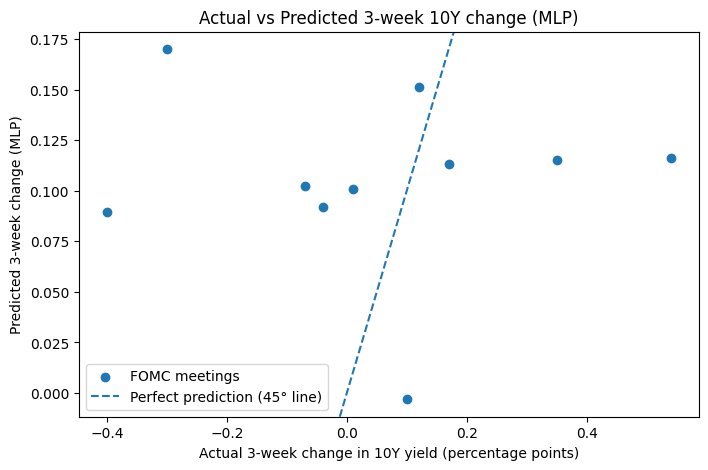

In [43]:
tfidf_mlp_reg: Pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 2),
        max_df=0.95,
        min_df=2,
        stop_words='english',
    )),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        max_iter=500,
        random_state=42,
    )),
])

tfidf_mlp_reg.fit(X_train, y_train)
y_pred_mlp: np.ndarray = tfidf_mlp_reg.predict(X_test)

mse_mlp: float = mean_squared_error(y_test, y_pred_mlp)
rmse_mlp: float = float(np.sqrt(mse_mlp))
r2_mlp: float = float(r2_score(y_test, y_pred_mlp))

print('MLP regression:')
print(f'  Test RMSE        : {rmse_mlp:.4f} percentage points')
print(f'  Baseline RMSE    : {baseline_rmse:.4f} (predict train mean)')
print(f'  Test R^2         : {r2_mlp:.3f}')

plt.scatter(y_test, y_pred_mlp, label='FOMC meetings')
plt.axline((0, 0), slope=1, linestyle='--', label='Perfect prediction (45° line)')
plt.xlabel('Actual 3-week change in 10Y yield (percentage points)')
plt.ylabel('Predicted 3-week change (MLP)')
plt.title('Actual vs Predicted 3-week 10Y change (MLP)')
plt.legend()
plt.show()

**Interpreting Ridge vs MLP in Part 1:**

- If the MLP achieves a similar or slightly better RMSE than Ridge, this suggests that some
  non-linearities in the text–yield relationship are being captured.
- If the MLP performs worse, emphasize **overfitting risk** and the importance of sample size.
- In either case, the comparison is valuable as a teaching device: the architecture changes, but
  the data pipeline (scraping → TF–IDF → model) stays the same.


---

## Part 2 – Policy surprise classification (Option B)

**Economic motivation:** A central object in monetary economics is a **monetary policy surprise**—
the unexpected component of a policy decision. In empirical work, this is often proxied by changes
in interest rate futures or yields in a narrow window around the policy announcement.

Here we build a **simple proxy** using the 2-year Treasury yield:

- Let $y^{(2)}_{t-1}$ be the 2-year yield on (or just before) the day **before** the meeting.
- Let $y^{(2)}_{t}$ be the 2-year yield on (or just before) the **meeting date**.
- Define the surprise as $\Delta y^{(2)}_t = y^{(2)}_t - y^{(2)}_{t-1}$.
- For meetings where $|\Delta y^{(2)}_t|$ exceeds a small threshold, we:
  - Label the meeting as **hawkish** (1) if $\Delta y^{(2)}_t > 0$.
  - Label it as **dovish** (0) if $\Delta y^{(2)}_t < 0$.

Our **classification task**:
- Use the minutes text to predict whether the meeting is perceived as hawkish or dovish.
- Compare a **logistic regression** baseline to an **MLP classifier**.


In [44]:
# Pull 2-year yields over the same date range
print('Fetching DGS2 from', start_date, 'to', end_date)
dgs2: pd.DataFrame = pdr.DataReader('DGS2', 'fred', start_date, end_date)
dgs2 = dgs2.rename(columns={'DGS2': 'dgs2'})
dgs2['dgs2'] = pd.to_numeric(dgs2['dgs2'], errors='coerce')
dgs2 = dgs2.sort_index().ffill().dropna()
dgs2.head()

Fetching DGS2 from 2020-01-22 to 2025-11-26


,dgs2
DATE,
2020-01-22,1.53
2020-01-23,1.51
2020-01-24,1.49
2020-01-27,1.44
2020-01-28,1.45


In [45]:
def get_yield_on_or_before_series(series: pd.Series, date: dt.date) -> float:
    """Return the last available yield from `series` on or before `date`."""
    ts: pd.Series = series.loc[:pd.to_datetime(date)]
    if ts.empty:
        return float('nan')
    return float(ts.iloc[-1])


def get_before_after_dgs2(date: dt.date) -> Tuple[float, float]:
    """Return (yield_before, yield_after) around a meeting date for DGS2.

    - `yield_before` is the yield on/before `date - 1 day`.
    - `yield_after` is the yield on/before `date`.
    """
    before_date: dt.date = date - dt.timedelta(days=1)
    before: float = get_yield_on_or_before_series(dgs2['dgs2'], before_date)
    after: float = get_yield_on_or_before_series(dgs2['dgs2'], date)
    return before, after

before_list: List[float] = []
after_list: List[float] = []
for d in minutes_df['meeting_date']:
    b, a = get_before_after_dgs2(d)
    before_list.append(b)
    after_list.append(a)

minutes_df['dgs2_before'] = before_list
minutes_df['dgs2_after'] = after_list
minutes_df['dgs2_surprise'] = minutes_df['dgs2_after'] - minutes_df['dgs2_before']

minutes_df[['meeting_date', 'dgs2_before', 'dgs2_after', 'dgs2_surprise']].tail()

,meeting_date,dgs2_before,dgs2_after,dgs2_surprise
42,2025-05-07,3.78,3.78,0.00
43,2025-06-18,3.94,3.94,0.00
44,2025-07-30,3.86,3.94,0.08
45,2025-09-17,3.51,3.52,0.01
46,2025-10-29,3.47,3.59,0.12


In [46]:
# Build a classification dataset: only meetings with a "significant" surprise
# Here we use a 3-basis-point threshold to have enough examples for teaching.
THRESHOLD_BPS: float = 0.03  # 3 basis points (0.03 percentage points)

cls_df: pd.DataFrame = minutes_df.dropna(subset=['dgs2_surprise', 'text']).copy()
cls_df = cls_df[np.abs(cls_df['dgs2_surprise']) >= THRESHOLD_BPS]

# Binary label: 1 = hawkish (yield up), 0 = dovish (yield down)
cls_df = cls_df[cls_df['dgs2_surprise'] != 0]
cls_df['label'] = (cls_df['dgs2_surprise'] > 0).astype(int)

print(f'Number of meetings with |2Y surprise| >= {THRESHOLD_BPS:.2f} ppts:', len(cls_df))
print('Label counts (0=dovish, 1=hawkish) in full sample:')
print(cls_df['label'].value_counts())

X_text_cls: np.ndarray = cls_df['text'].values
y_cls: np.ndarray = cls_df['label'].values

Number of meetings with |2Y surprise| >= 0.03 ppts: 28
Label counts (0=dovish, 1=hawkish) in full sample:
label
0    17
1    11
Name: count, dtype: int64


Note: with high thresholds and a short sample, the classification dataset can be very small
(sometimes fewer than 10 observations in the test set). That is **not a bug**, but a reality of
trying to infer surprises from a limited history of meetings. For teaching, we lower the threshold
slightly (3 basis points) to have a bit more data while still focusing on economically meaningful
moves.


### 2.1 Baseline: TF–IDF + logistic regression

We start with a **linear classifier** on TF–IDF features: logistic regression.

- This estimates a linear decision boundary in the high-dimensional TF–IDF space.
- Economically, it finds word/phrase combinations that tilt the perceived surprise toward
  *hawkish* or *dovish*.

Because our dataset is small and labels may be imbalanced, we also compute a **majority-class
baseline** for test accuracy, to see whether the model improves on simply always predicting the
most common class.


In [47]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_text_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

print(f'Train size: {len(X_train_c)}, Test size: {len(X_test_c)}')
print('Train label distribution:')
print(pd.Series(y_train_c).value_counts())
print('Test label distribution:')
print(pd.Series(y_test_c).value_counts())

tfidf_logit: Pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 2),
        max_df=0.95,
        min_df=2,
        stop_words='english',
    )),
    ('logit', LogisticRegression(max_iter=1000)),
])

tfidf_logit.fit(X_train_c, y_train_c)
y_pred_logit: np.ndarray = tfidf_logit.predict(X_test_c)

acc_logit: float = float(accuracy_score(y_test_c, y_pred_logit))

# Majority-class baseline
majority_class: int = int(pd.Series(y_train_c).value_counts().idxmax())
baseline_acc: float = float(np.mean(y_test_c == majority_class))

print(f'Logistic regression accuracy: {acc_logit:.3f}')
print(f'Majority-class baseline accuracy: {baseline_acc:.3f}')
print('\nClassification report (logit):')
print(classification_report(y_test_c, y_pred_logit, zero_division=0))

print('Confusion matrix (logit):')
print(confusion_matrix(y_test_c, y_pred_logit))

Train size: 22, Test size: 6
Train label distribution:
0    13
1     9
Name: count, dtype: int64
Test label distribution:
0    4
1    2
Name: count, dtype: int64
Logistic regression accuracy: 0.667
Majority-class baseline accuracy: 0.667

Classification report (logit):
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       0.00      0.00      0.00         2

    accuracy                           0.67         6
   macro avg       0.33      0.50      0.40         6
weighted avg       0.44      0.67      0.53         6

Confusion matrix (logit):
[[4 0]
 [2 0]]


**How to read the classification output:**

- If the model **always predicts one class** (e.g. all meetings as dovish), then precision/recall
  for the other class will be zero, and scikit-learn would normally warn that precision is
  "ill-defined". We set `zero_division=0` to avoid noisy warnings and highlight this behavior in
  the confusion matrix.
- Compare the model's accuracy to the **majority-class baseline**:
  - If accuracy ≈ baseline, the text is not adding much.
  - If accuracy > baseline, the model is extracting some useful information from the text.
- Given the tiny test sample, emphasize to students that results are **high-variance** and should
  not be overinterpreted.


### 2.2 TF–IDF + neural-net classifier (MLPClassifier)

Next we use the same TF–IDF representation but feed it into a small **MLP classifier**:

- 2 hidden layers of sizes (64, 32) with ReLU activations.
- Optimized via backpropagation.

Conceptually, this allows for **non-linear interactions** between terms, at the cost of more
parameters and potentially more overfitting. With limited data, performance differences will
not necessarily be huge, but the example demonstrates how to integrate neural networks into
econ text classification tasks.


In [48]:
tfidf_mlp_cls: Pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 2),
        max_df=0.95,
        min_df=2,
        stop_words='english',
    )),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        max_iter=500,
        random_state=42,
    )),
])

tfidf_mlp_cls.fit(X_train_c, y_train_c)
y_pred_mlp_c: np.ndarray = tfidf_mlp_cls.predict(X_test_c)

acc_mlp_c: float = float(accuracy_score(y_test_c, y_pred_mlp_c))

print(f'MLP classifier accuracy: {acc_mlp_c:.3f}')
print(f'Majority-class baseline accuracy: {baseline_acc:.3f}')
print('\nClassification report (MLP):')
print(classification_report(y_test_c, y_pred_mlp_c, zero_division=0))

print('Confusion matrix (MLP):')
print(confusion_matrix(y_test_c, y_pred_mlp_c))

MLP classifier accuracy: 1.000
Majority-class baseline accuracy: 0.667

Classification report (MLP):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

Confusion matrix (MLP):
[[4 0]
 [0 2]]


**Interpreting Part 2 results:**

- Look at whether either model (logit or MLP) beats the **majority-class baseline** by a
  meaningful margin.
- Examine which class is being predicted more accurately (hawkish vs dovish) via precision/recall.
- Emphasize the small sample size: with only a handful of significant surprises, forecasts will
  be noisy, and the primary goal is to understand how to **build the labels and set up the
  classification problem**, not to claim strong out-of-sample performance.


---

## Part 3 – FinBERT-FOMC sentiment index (Option C)

In current research, economists rarely train deep models *from scratch* on FOMC text, because the
sample is too small. Instead, they:

1. Start from a **pre-trained language model** (trained on large corpora).
2. Fine-tune it on central bank text (or use an existing fine-tuned model).
3. Use the model either:
   - as a **feature extractor** (embedding/sentiment scores), or
   - as a **classifier** for specific labels (stance, sentiment, topics).

Here we use **FinBERT-FOMC** (a FinBERT variant trained on FOMC minutes) to construct a very simple
**sentiment index** for each minutes document:

\[
s_t = P(\text{Positive}) - P(\text{Negative}),
\]

and then use this scalar index in a regression for the 3-week 10-year yield change.

> **Practical note:** Part 3 requires the `transformers` and `torch` libraries. If they are not
> installed, the code below will print a message and skip the FinBERT computations instead of
> crashing.


In [49]:
try:
    from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
    _TRANSFORMERS_AVAILABLE: bool = True
except ModuleNotFoundError:
    print('The `transformers` library is not installed. Install it with '\
          '`pip install transformers torch` to run Part 3 (FinBERT-FOMC).')
    AutoTokenizer = AutoModelForSequenceClassification = pipeline = None
    _TRANSFORMERS_AVAILABLE = False

FINBERT_MODEL_NAME: str = 'ZiweiChen/FinBERT-FOMC'

finbert_pipeline: Optional[Any] = None
if _TRANSFORMERS_AVAILABLE:
    finbert_pipeline = pipeline(
        task='text-classification',
        model=FINBERT_MODEL_NAME,
        tokenizer=FINBERT_MODEL_NAME,
        return_all_scores=True,
        truncation=True,
    )
    # Quick sanity check on a short sentence
    print(finbert_pipeline('This is a short test sentence about monetary policy.'))


Device set to use mps:0
/Users/zfeng/Library/CloudStorage/OneDrive-Personal/Teaching_Notes/AI_ML/Lecture_notes_2026/Notebooks/.venv/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[[{'label': 'Neutral', 'score': 0.9791320562362671}, {'label': 'Positive', 'score': 0.004978015087544918}, {'label': 'Negative', 'score': 0.015889903530478477}]]


### 3.1 Compute FinBERT-FOMC sentiment for each minutes document

The FinBERT-FOMC model returns scores for labels like **Positive**, **Negative**, and **Neutral**.
We:

- (For speed) truncate the minutes to the first ~2000 characters (still a rich summary).
- Pass the text to the model and collect the label scores.
- Define a scalar **sentiment index** as `score = P(positive) − P(negative)`.
- Store positive, negative, neutral probabilities and the score in `minutes_df`.

If `transformers` was not installed, this cell will skip computation and fill these columns with
`NaN`, so later cells can still run (though Part 3's regression will have no data).


In [50]:
def finbert_sentiment_for_text(text: str) -> Tuple[float, float, float, float]:
    """Return (pos, neg, neu, score) for a given text using FinBERT-FOMC.

    Parameters
    ----------
    text : str
        Raw minutes text.

    Returns
    -------
    Tuple[float, float, float, float]
        (P(positive), P(negative), P(neutral), score = P(pos) - P(neg)).
        Returns (nan, nan, nan, nan) if text is empty or FinBERT is unavailable.
    """
    if finbert_pipeline is None:
        return float('nan'), float('nan'), float('nan'), float('nan')

    if not isinstance(text, str) or not text.strip():
        return float('nan'), float('nan'), float('nan'), float('nan')

    # FinBERT is trained on sentence/paragraph level; we truncate long minutes
    # to keep runtime manageable while retaining a representative sample.
    short_text: str = text[:2000]

    outputs: List[Dict[str, Any]] = finbert_pipeline(short_text)[0]  # list of dicts for each label
    label2score: Dict[str, float] = {d['label'].lower(): float(d['score']) for d in outputs}

    pos: float = label2score.get('positive', 0.0)
    neg: float = label2score.get('negative', 0.0)
    neu: float = label2score.get('neutral', 0.0)
    score: float = pos - neg
    return pos, neg, neu, score

finbert_pos: List[float] = []
finbert_neg: List[float] = []
finbert_neu: List[float] = []
finbert_score: List[float] = []

for txt in minutes_df['text']:
    p, n, u, s = finbert_sentiment_for_text(txt)
    finbert_pos.append(p)
    finbert_neg.append(n)
    finbert_neu.append(u)
    finbert_score.append(s)

minutes_df['finbert_pos'] = finbert_pos
minutes_df['finbert_neg'] = finbert_neg
minutes_df['finbert_neu'] = finbert_neu
minutes_df['finbert_score'] = finbert_score

minutes_df[['meeting_date', 'finbert_pos', 'finbert_neg', 'finbert_neu', 'finbert_score']].head()

,meeting_date,finbert_pos,finbert_neg,finbert_neu,finbert_score
0,2020-01-29,0.060171,0.020532,0.919297,0.039638
1,2020-03-15,0.065240,0.020224,0.914535,0.045016
2,2020-04-29,0.059712,0.019617,0.920671,0.040095
3,2020-06-10,0.058207,0.019527,0.922266,0.038680
4,2020-07-29,0.065121,0.021885,0.912993,0.043236


### 3.2 Using the FinBERT sentiment index to predict 10-year yields

Finally, we treat the **FinBERT sentiment index** as a single explanatory variable and regress
the 3-week 10-year yield change on it.

This is intentionally simple, mirroring empirical papers that:
- First build a **text-based index** using a deep model.
- Then use that index in otherwise familiar econometric setups (OLS, VARs, etc.).


FinBERT sentiment regression:
  Test RMSE: 0.2534 percentage points
  Test R^2 : 0.084


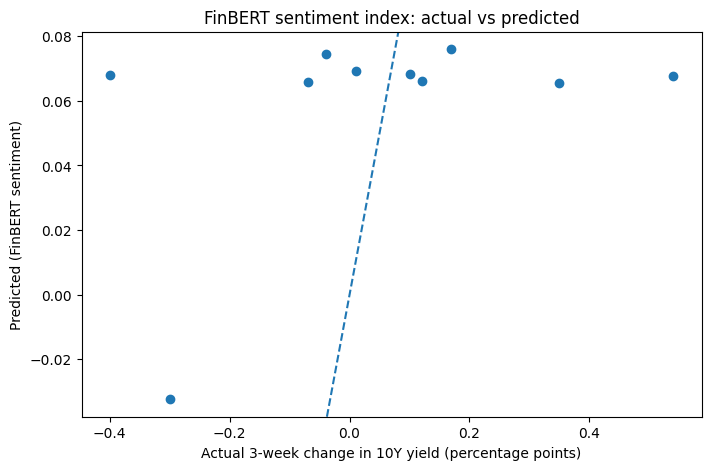

In [51]:
sent_df: pd.DataFrame = minutes_df.dropna(subset=['target_return', 'finbert_score']).copy()

if sent_df.empty:
    print('No FinBERT sentiment data available (likely because transformers is not installed).')
else:
    X_sent: np.ndarray = sent_df[['finbert_score']].values
    y_sent: np.ndarray = sent_df['target_return'].values

    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
        X_sent, y_sent, test_size=0.2, random_state=42
    )

    ridge_sent: Ridge = Ridge(alpha=1.0)
    ridge_sent.fit(X_train_s, y_train_s)
    y_pred_s: np.ndarray = ridge_sent.predict(X_test_s)

    mse_s: float = mean_squared_error(y_test_s, y_pred_s)
    rmse_s: float = float(np.sqrt(mse_s))
    r2_s: float = float(r2_score(y_test_s, y_pred_s))

    print('FinBERT sentiment regression:')
    print(f'  Test RMSE: {rmse_s:.4f} percentage points')
    print(f'  Test R^2 : {r2_s:.3f}')

    plt.scatter(y_test_s, y_pred_s)
    plt.axline((0, 0), slope=1, linestyle='--')
    plt.xlabel('Actual 3-week change in 10Y yield (percentage points)')
    plt.ylabel('Predicted (FinBERT sentiment)')
    plt.title('FinBERT sentiment index: actual vs predicted')
    plt.show()

**Interpreting Part 3 results:**

- If `transformers` is installed, we obtain a small sample of (FinBERT score, yield change)
  observations and fit a simple regression.
- As before, we should not expect a high $R^2$. The goal is to show how a **deep pre-trained
  model** can compress rich FOMC text into a **low-dimensional index** that can be plugged into
  standard econometric workflows.
- You can ask students to compare this to the TF–IDF models:
  - Is the sentiment index more interpretable?
  - Does it perform comparably with far fewer features?


---

## 4. Summary and teaching points

Across the three parts, we have built a **coherent story** of how unstructured central-bank text
can be used in empirical macro-finance:

1. **Part 1 – Classical NLP + Tiny Neural Net**
   - Converted FOMC minutes into **TF–IDF vectors**.
   - Used those vectors to predict a simple target (3-week change in the 10-year yield) via
     **Ridge** and a small **MLP**.
   - Compared performance to a naive **mean forecast baseline**.

2. **Part 2 – Policy Surprise Classification**
   - Constructed a proxy for **monetary policy surprises** using changes in the 2-year yield.
   - Used minutes text to classify surprises as **hawkish vs dovish** with logistic regression
     and an MLP classifier.
   - Compared performance to a **majority-class baseline** and interpreted confusion matrices.

3. **Part 3 – Deep Pre-trained Model (FinBERT-FOMC)**
   - Applied a transformer-based sentiment model, **FinBERT-FOMC**, to FOMC minutes.
   - Constructed a one-dimensional **sentiment index** and used it in a simple regression.
   - Illustrated how deep models often act as **feature extractors**, feeding into familiar
     econometric frameworks.

### Possible extensions for students

- Replace the 3-week horizon with alternative horizons (1 day, 1 month, etc.).
- Use FOMC **statements** or **press conference transcripts** instead of minutes.
- Build more refined surprise measures using high-frequency futures data.
- Place the text-based indices into a **VAR** with inflation, unemployment, and output.
- Compare domain-specific models (FinBERT-FOMC, CentralBankRoBERTa) with generic BERT/RoBERTa.

From a teaching standpoint, this notebook demonstrates the full pipeline:

1. **Scrape** real-world unstructured economic data.
2. **Clean and parse** it into a tidy tabular form.
3. **Construct economically meaningful targets** and labels.
4. **Apply ML and deep NLP tools** in a way that respects the underlying economics.
